In [62]:
import os
import pickle

import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np

from model import FiringRateModel, PolynomialActivation, train_model
from data import load_data, preprocess_data

In [63]:
#device = torch.device("mps")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [64]:
def test_model(model, criterion, Is, fs, k: int):
    with torch.no_grad():
        f = fs[0] # initialize firing rate to t=0
        loss = 0
        n = 0
        for i in range(k+1, len(Is)):
            currs = Is[i-k:i+1]
            f = model(currs, f)
            loss += criterion(f, fs[i]).item()
            n += 1
    return loss / n

def predict(model, Is, fs, k: int):
    with torch.no_grad():
        f = fs[0] # initialize firing rate to t=0
        pred_fs = []
        for i in range(k+1, len(Is)):
            currs = Is[i-k:i+1]
            f = model(currs, f)
            pred_fs.append(f)
    return pred_fs

def plot_predictions(model, Is, fs, k: int):
    pred_fs = predict(model, Is, fs, k)
    ts = list(range(1, len(fs)))
    plt.plot(ts, fs[1:], label="Actual")
    plt.plot(ts, pred_fs, label="Predicted")
    plt.legend()
    plt.ylabel("Firing rate")
    plt.xlabel("t")

In [65]:
data = load_data(with_zero=True)
data.keys()

dict_keys([583836069, 565871768, 605889373])

In [66]:
def get_train_test_data(data, cell_id, bin_size):
    Is_tr, fs_tr, Is_te, fs_te = tuple([] for _ in range(4))
    
    for sweep in data[cell_id][:-1]:
        stim_name = sweep["stimulus_name"]
        Is = torch.tensor(sweep["current"][bin_size], device=device)
        fs = torch.tensor(sweep["firing_rate"][bin_size], device=device)
        if stim_name == "Noise 2":
            Is_te.append(Is)
            fs_te.append(fs)
        elif stim_name != "Test":
            Is_tr.append(Is)
            fs_tr.append(fs)
    return Is_tr, fs_tr, Is_te, fs_te

def data_lens(Is):
    lens = [len(a) for a in Is]
    counts = {}
    for l in lens:
        if l not in counts:
            counts[l] = 0
        counts[l] += 1
    print(counts)

In [87]:
bin_size = 50
cell_id = 605889373
k = 2
loss_fn = "poisson"
Is_tr, fs_tr, Is_te, fs_te = get_train_test_data(data, cell_id, bin_size)
data_lens(Is_tr)
data_lens(Is_te)

{25: 17, 145: 25, 185: 2, 105: 12, 545: 3, 180: 1, 149: 10}
{545: 3}


In [88]:
actv = PolynomialActivation()
actv.init_from_file(f"model/activation/{loss_fn}/bin_size_{bin_size}/{cell_id}_1e-05.pickle")

model = FiringRateModel(actv, k=k).to(device)
if loss_fn == "poisson":
    criterion = torch.nn.PoissonNLLLoss(log_input=False)
elif loss_fn == "huber":
    criterion = torch.nn.HuberLoss()
    #criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

train_model(
    model, 
    criterion, 
    optimizer,
    Is_tr,
    fs_tr,
    k,
    epochs = 10,
    print_every = 1,
    loss_fn = loss_fn,
    bin_size = bin_size,
    up_factor = 2
)
'''
train_loss = test_model(
    model, 
    criterion, 
    Is_tr,
    fs_tr,
    k
)

test_loss = test_model(
    model, 
    criterion, 
    Is_te,
    fs_te,
    k
)

print(f"\nTrain Loss: {train_loss}")
print(f"Test Loss: {test_loss}")''';

Epoch 1 / Loss: 5058.5484120845795
Epoch 2 / Loss: 6207.506568908691
Epoch 3 / Loss: 8057.92608833313
Epoch 4 / Loss: 7877.722972869873
Epoch 5 / Loss: 7585.755784988403
Epoch 6 / Loss: 7136.44785118103
Epoch 7 / Loss: 6432.2572321891785
Epoch 8 / Loss: 5421.090110778809
Epoch 9 / Loss: 4637.068947315216
Epoch 10 / Loss: 5346.826159477234


/var/folders/1d/cmypn_251jlfyvc132scjqd40000gp/T/ipykernel_21340/2504273869.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


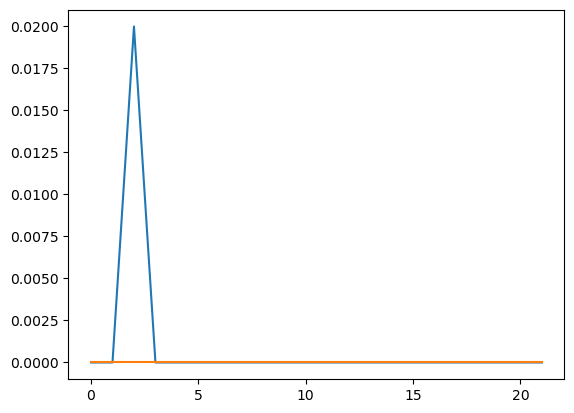

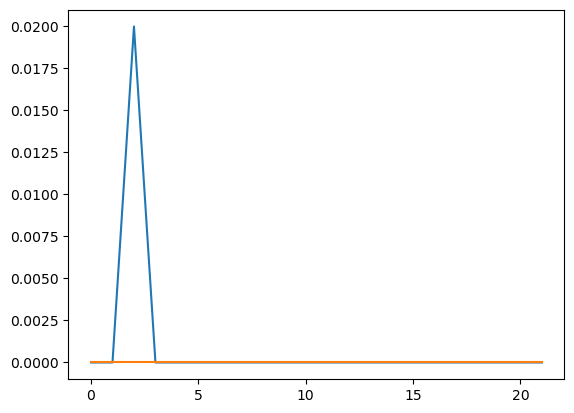

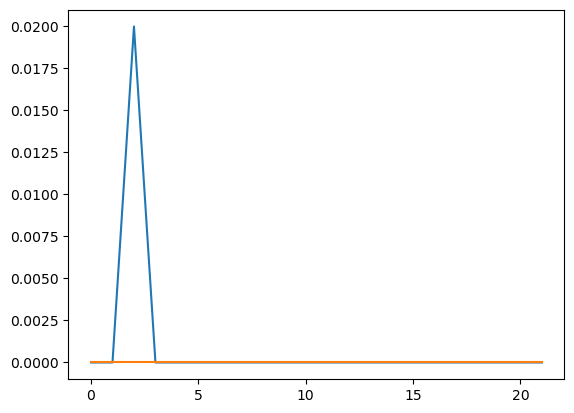

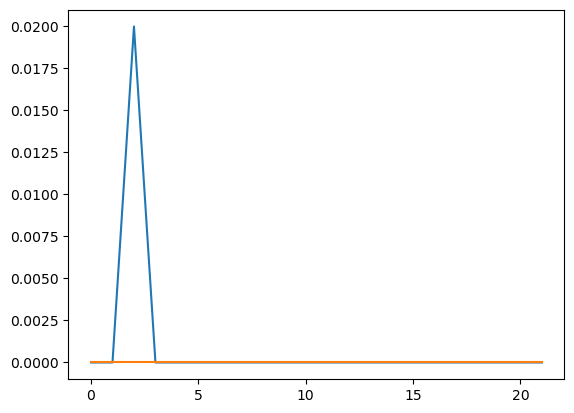

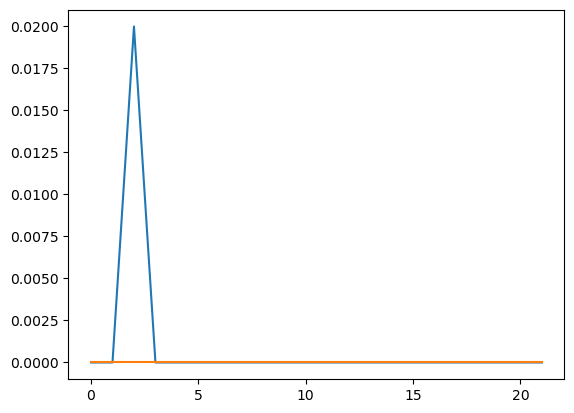

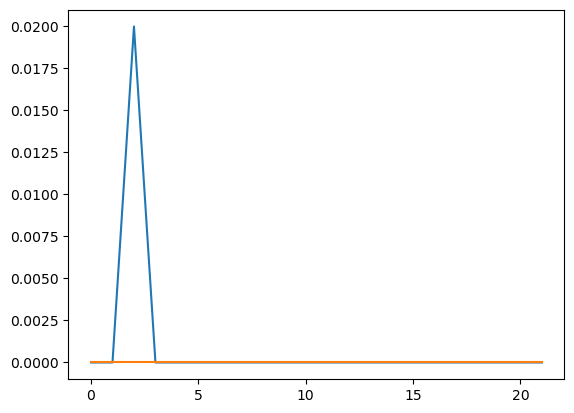

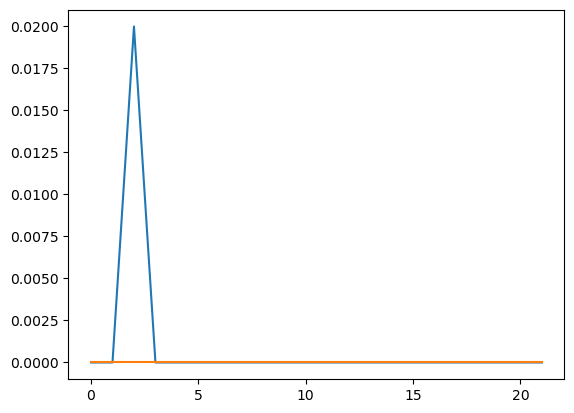

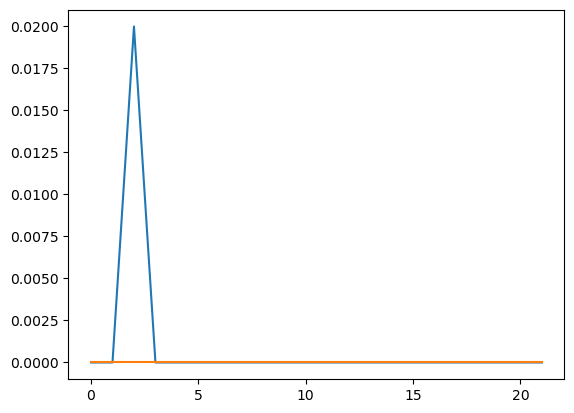

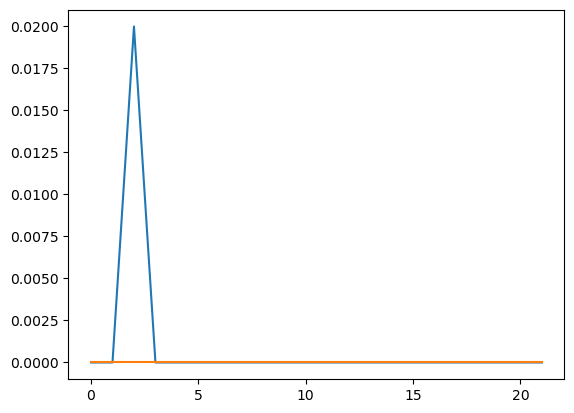

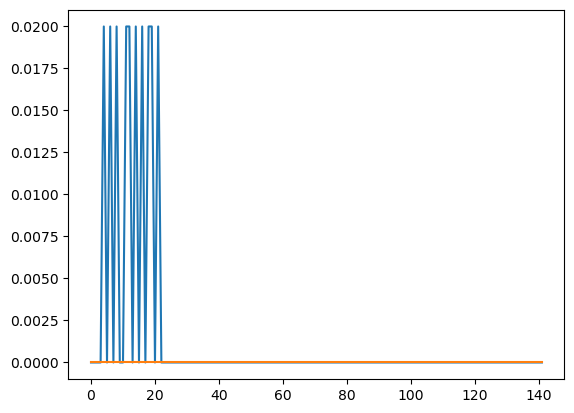

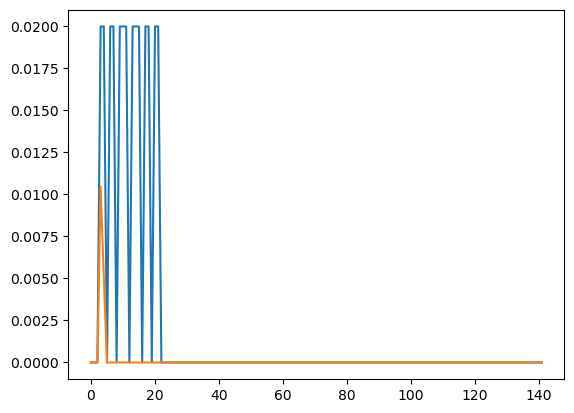

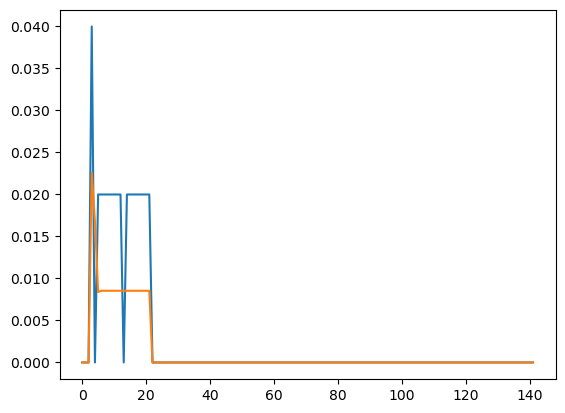

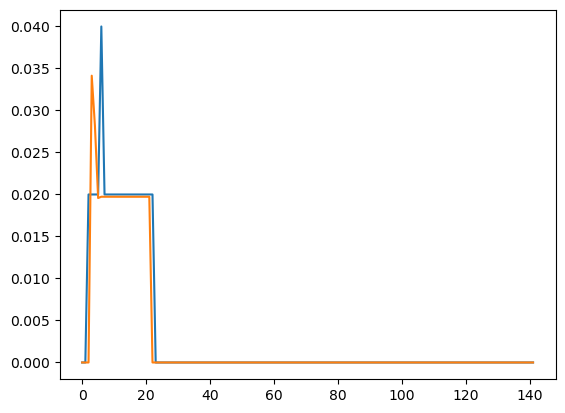

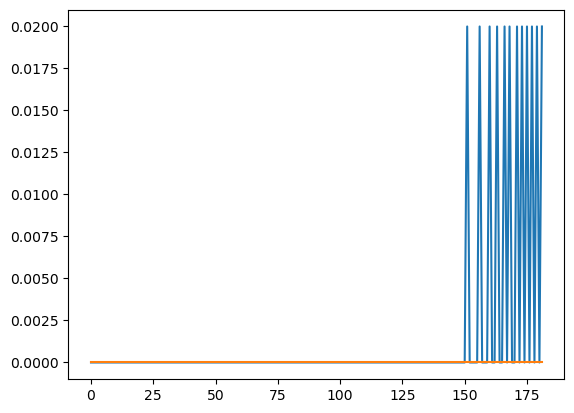

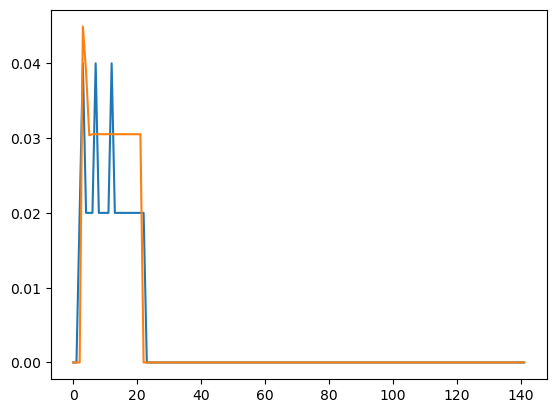

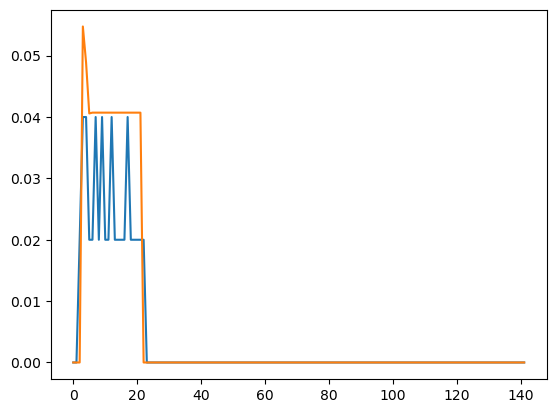

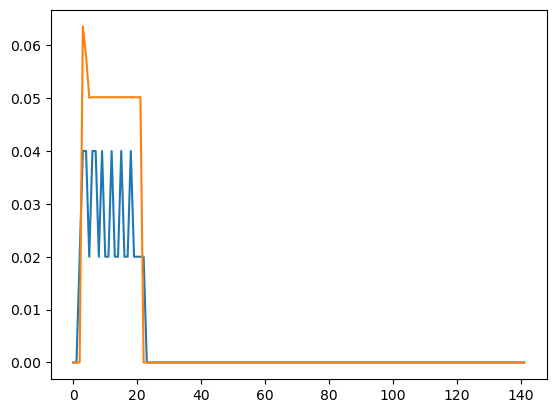

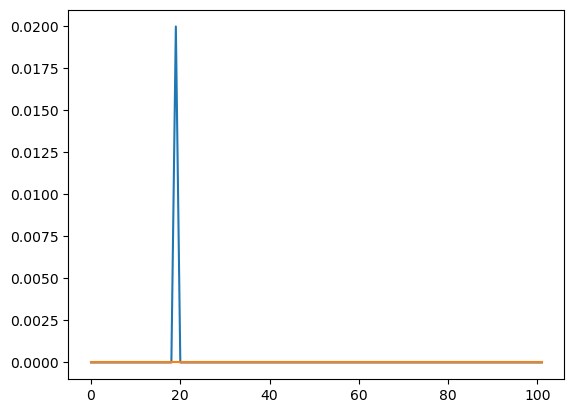

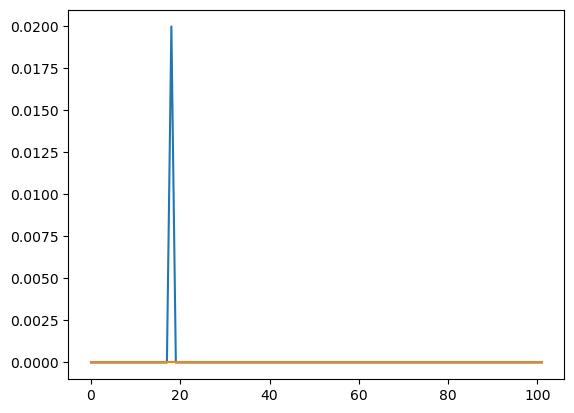

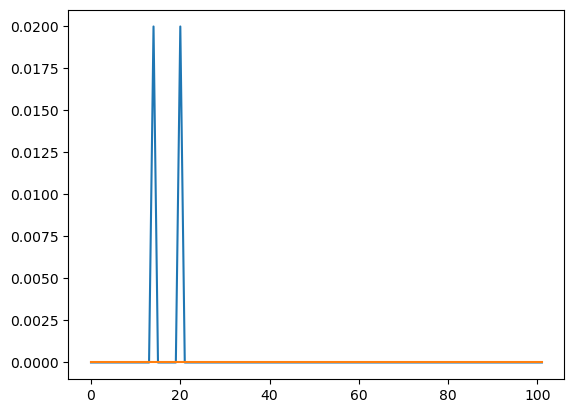

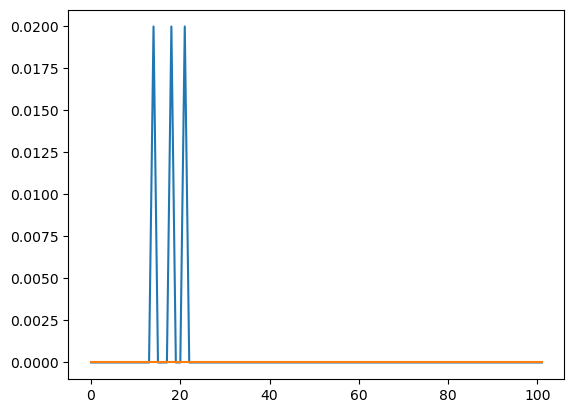

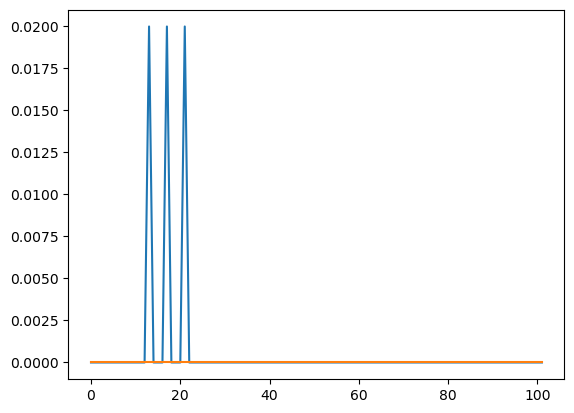

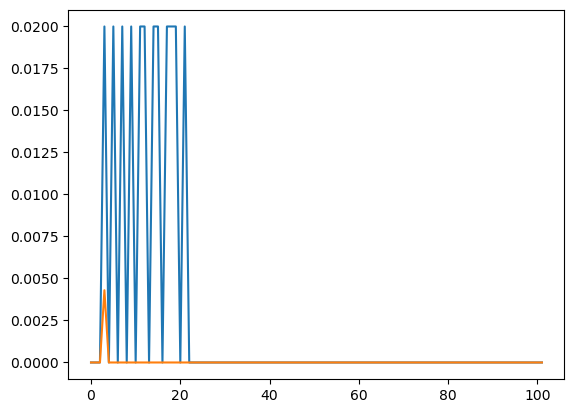

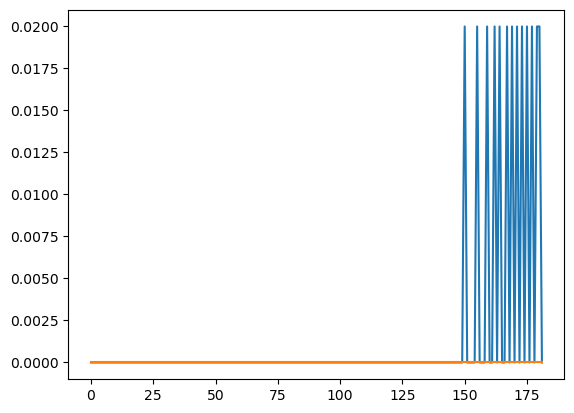

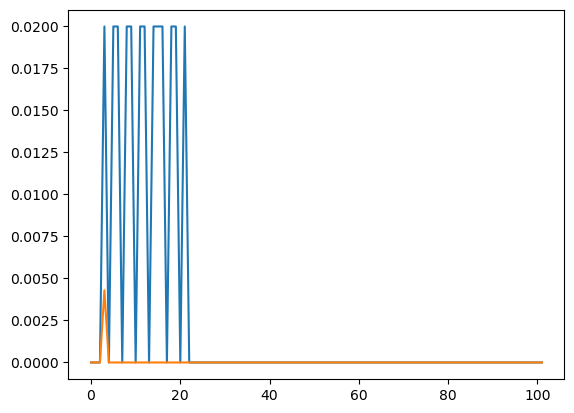

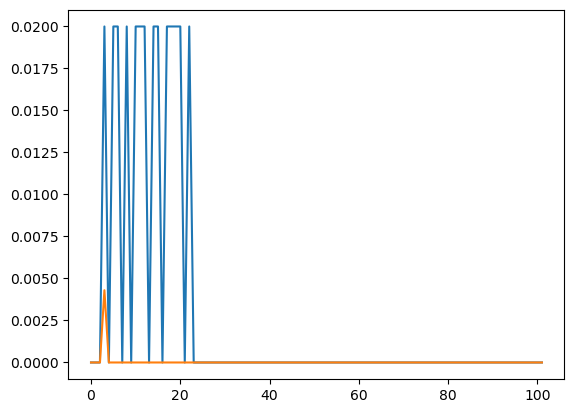

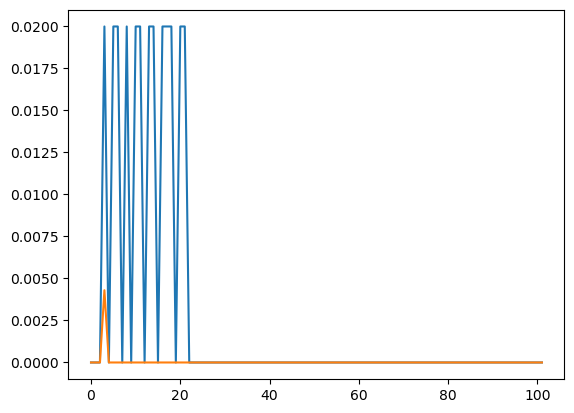

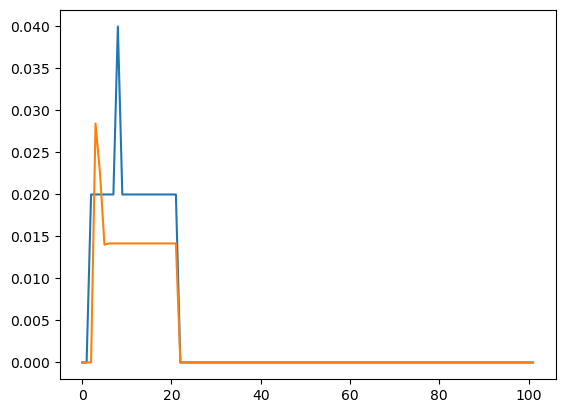

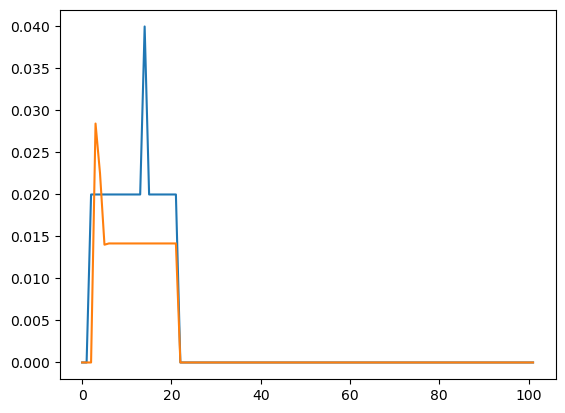

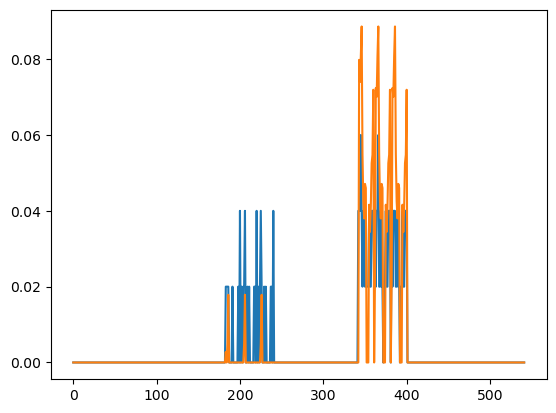

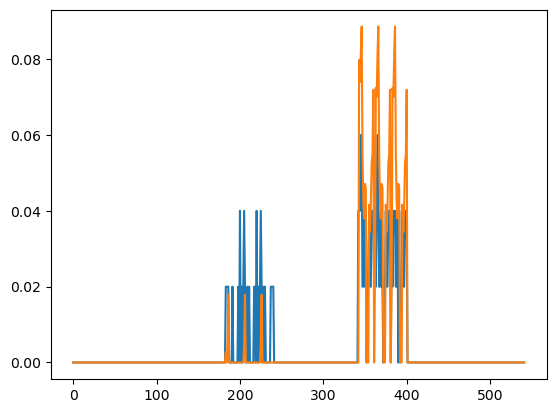

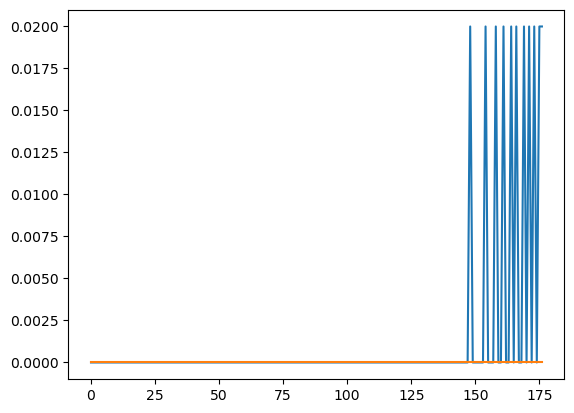

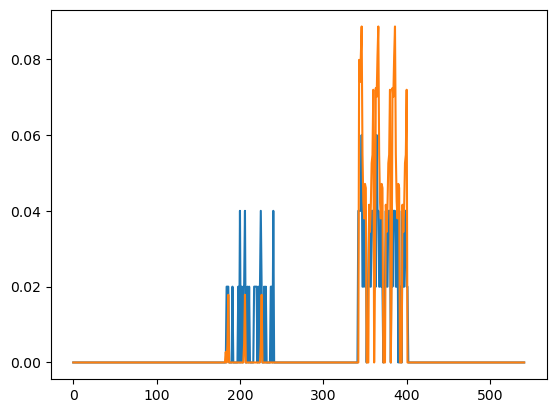

In [89]:
for i in range(len(Is_tr)):
    if not torch.all(fs_tr[i] <= 0.01):
        plt.figure()
        pred_fs = predict(model, Is_tr[i], fs_tr[i], k)
        ts = list(range(len(Is_tr[i])-k-1))
        plt.plot(ts, fs_tr[i][k+1:])
        plt.plot(ts, pred_fs)

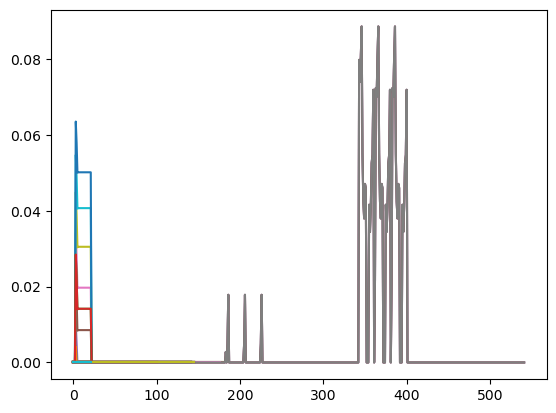

In [90]:
for i in range(len(Is_tr)):
    pred_fs = predict(model, Is_tr[i], fs_tr[i], k)
    ts = list(range(len(Is_tr[i])-k-1))
    #plt.plot(ts, fs_tr[i][k+1:])
    plt.plot(ts, pred_fs)

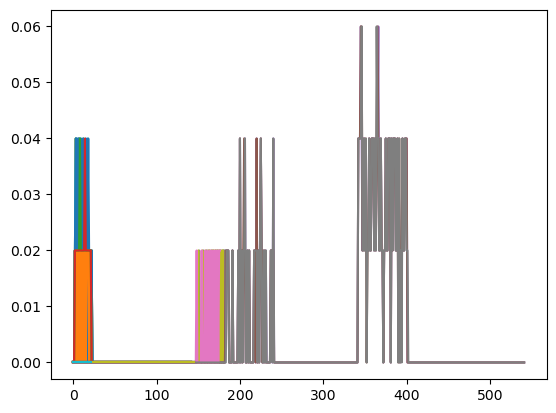

In [91]:
for i in range(len(Is_tr)):
    #plt.figure()
    pred_fs = predict(model, Is_tr[i], fs_tr[i], k)
    ts = list(range(len(Is_tr[i])-k-1))
    plt.plot(ts, fs_tr[i][k+1:])
    #plt.plot(ts, pred_fs)

In [92]:
print(model.a, model.b)
print(model.g.poly_coeff)

Parameter containing:
tensor([-0.1046,  0.0893], requires_grad=True) Parameter containing:
tensor(30.6701, requires_grad=True)
Parameter containing:
tensor([ 3.2343e-01,  1.5173e+00, -1.9401e-12, -2.5474e-11,  3.5144e-12,
        -1.5782e-11])


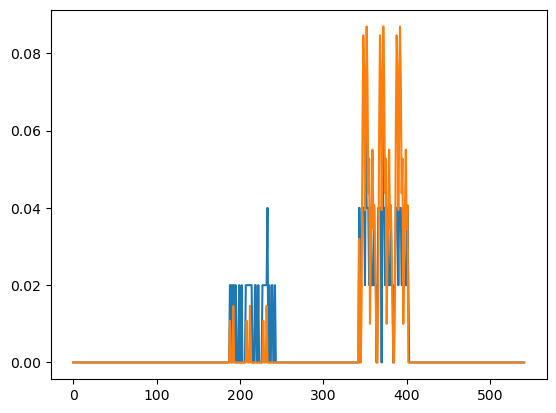

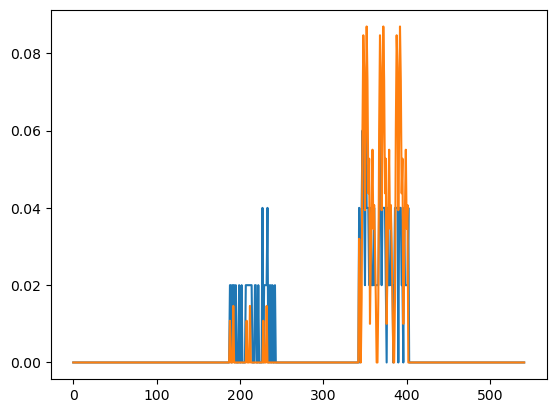

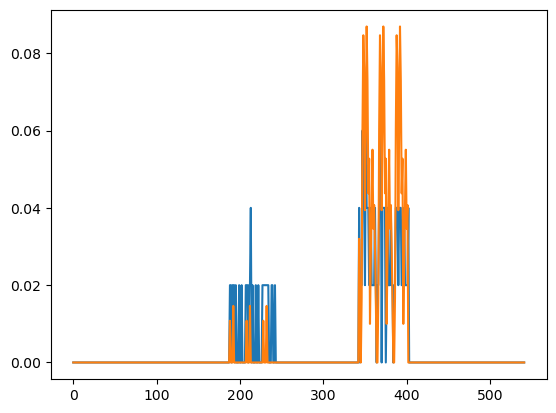

In [93]:
for i in range(len(Is_te)):
    if not torch.all(fs_te[i] <= 0.01):
        plt.figure()
        pred_fs = predict(model, Is_te[i], fs_te[i], k)
        ts = list(range(len(Is_te[i])-k-1))
        plt.plot(ts, fs_te[i][k+1:])
        plt.plot(ts, pred_fs)

In [106]:
def quantize(pred_fs):
    p = torch.tensor(pred_fs).clone()
    return (p * 50 + 0.5).type(torch.int32).type(torch.float32) / 50

In [114]:
from torcheval.metrics import R2Score

R^2:  tensor(0.2149)


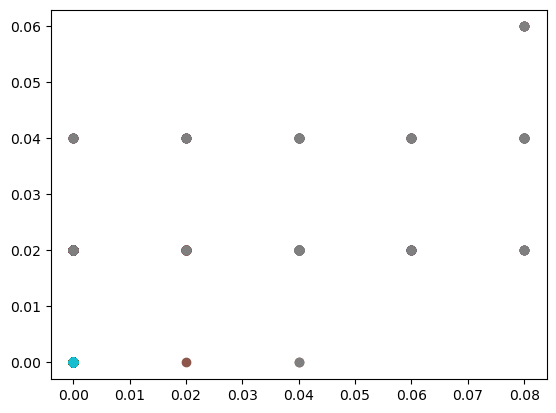

In [119]:
quantized_preds = []
truncated_fs = []
for i in range(len(Is_tr)):
    pred_fs = predict(model, Is_tr[i], fs_tr[i], k)
    p = quantize(pred_fs)
    quantized_preds.append(p)
    truncated_fs.append(fs_tr[i][k+1:])
    plt.scatter(p, fs_tr[i][k+1:])

metric = R2Score()
metric.update(torch.cat(quantized_preds), torch.cat(truncated_fs))
print("R^2:", metric.compute())

R^2:  tensor(0.1786)


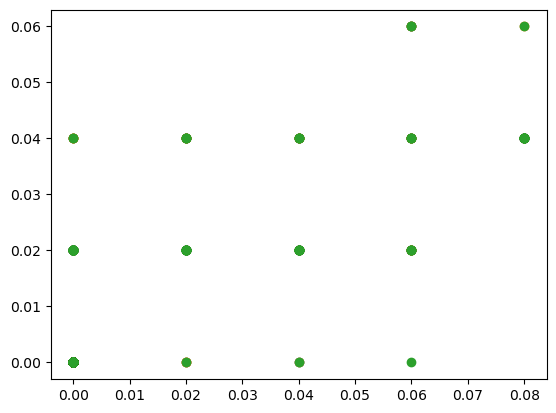

In [120]:
quantized_preds = []
truncated_fs = []
for i in range(len(Is_te)):
    #plt.figure()
    pred_fs = predict(model, Is_te[i], fs_te[i], k)
    p = quantize(pred_fs)
    quantized_preds.append(p)
    truncated_fs.append(fs_te[i][k+1:])
    plt.scatter(p, fs_te[i][k+1:])
    
metric = R2Score()
metric.update(torch.cat(quantized_preds), torch.cat(truncated_fs))
print("R^2:", metric.compute())